In [109]:
import scipy.io as sio

mat = sio.loadmat("C:/Users/DELL/Downloads/Indian_pines_corrected.mat")

In [110]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:47:44 2011',
 '__version__': '1.0',
 '__globals__': [],
 'indian_pines_corrected': array([[[3172, 4142, 4506, ..., 1057, 1020, 1020],
         [2580, 4266, 4502, ..., 1064, 1029, 1020],
         [3687, 4266, 4421, ..., 1061, 1030, 1016],
         ...,
         [2570, 3890, 4320, ..., 1042, 1021, 1015],
         [3170, 4130, 4320, ..., 1054, 1024, 1020],
         [3172, 3890, 4316, ..., 1043, 1034, 1016]],
 
        [[2576, 4388, 4334, ..., 1047, 1030, 1006],
         [2747, 4264, 4592, ..., 1055, 1039, 1015],
         [2750, 4268, 4423, ..., 1047, 1026, 1015],
         ...,
         [3859, 4512, 4605, ..., 1056, 1035, 1015],
         [3686, 4264, 4690, ..., 1051, 1012, 1020],
         [2744, 4268, 4597, ..., 1047, 1019, 1016]],
 
        [[2744, 4146, 4416, ..., 1055, 1029, 1025],
         [2576, 4389, 4416, ..., 1051, 1021, 1011],
         [2744, 4273, 4420, ..., 1068, 1033, 1010],
         ...,
       

In [111]:
gt = sio.loadmat("C:/Users/DELL/Downloads/Indian_pines_gt.mat")
gt

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:25:41 2011',
 '__version__': '1.0',
 '__globals__': [],
 'indian_pines_gt': array([[3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [112]:
len(mat['indian_pines_corrected'])

145

In [113]:
len(gt['indian_pines_gt'])

145

In [114]:
type(mat['indian_pines_corrected'][0])

numpy.ndarray

In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers.merge import add, concatenate
from keras.layers import AveragePooling2D
from tensorflow.keras.utils import plot_model
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

In [2]:
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [3]:
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [4]:
def loadData(name):
    data_path = "C:/Users/DELL/Downloads/"
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [6]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [8]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [9]:
#K = X.shape[2]

In [10]:
if dataset == 'IP':
    K = 16 
X,pca = applyPCA(X,numComponents=K)

X.shape


(145, 145, 16)

In [11]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 16), (10249,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 16), (7175, 25, 25, 16), (3074,), (7175,))

In [13]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 16, 1)

In [14]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [15]:
S = windowSize
L = K
if dataset =='IP':
    output_units = 16

In [16]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
#conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((19, 19, 128))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [17]:
model = Model(inputs=input_layer, outputs=output_layer)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 16, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 10, 8)     512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 6, 16)     5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 4, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0     

In [19]:
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [135]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - 46s 3s/step - loss: 2.4879 - accuracy: 0.1975
Epoch 2/100
13/13 [==============================] - 39s 3s/step - loss: 1.7988 - accuracy: 0.4063
Epoch 3/100
13/13 [==============================] - 38s 3s/step - loss: 1.1981 - accuracy: 0.5930
Epoch 4/100
13/13 [==============================] - 40s 3s/step - loss: 0.7784 - accuracy: 0.7411
Epoch 5/100
13/13 [==============================] - 41s 3s/step - loss: 0.4465 - accuracy: 0.8601
Epoch 6/100
13/13 [==============================] - 41s 3s/step - loss: 0.2318 - accuracy: 0.9281
Epoch 7/100
13/13 [==============================] - 38s 3s/step - loss: 0.1562 - accuracy: 0.9480
Epoch 8/100
13/13 [==============================] - 40s 3s/step - loss: 0.0915 - accuracy: 0.9681
Epoch 9/100
13/13 [==============================] - 36s 3s/step - loss: 0.0883 - accuracy: 0.9691
Epoch 10/100
13/13 [==============================] - 36s 3s/step - loss: 0.1052 - accuracy: 0.9639
Epoch 11/

13/13 [==============================] - 38s 3s/step - loss: 0.0053 - accuracy: 0.9984
Epoch 96/100
13/13 [==============================] - 31s 2s/step - loss: 0.0027 - accuracy: 0.9993
Epoch 97/100
13/13 [==============================] - 31s 2s/step - loss: 0.0019 - accuracy: 0.9993
Epoch 98/100
13/13 [==============================] - 31s 2s/step - loss: 0.0057 - accuracy: 0.9984
Epoch 99/100
13/13 [==============================] - 32s 2s/step - loss: 0.0019 - accuracy: 0.9990
Epoch 100/100
13/13 [==============================] - 31s 2s/step - loss: 0.0049 - accuracy: 0.9987


In [139]:
model.save("C:/Users/DELL/Desktop/best-model.hdf5")

In [21]:
model.load_weights("C:/Users/DELL/Desktop/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [22]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 16, 1)

In [23]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [143]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00      1000
           2       1.00      0.99      1.00       581
           3       1.00      1.00      1.00       166
           4       0.99      1.00      1.00       338
           5       1.00      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       0.88      1.00      0.93        14
           9       1.00      1.00      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      1.00      1.00       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00        65

    accuracy                           1.00      7175
   macro avg       0.99   

In [24]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [25]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [26]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "C:/Users/DELL/Desktop/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 11s 46ms/step - loss: 0.0093 - accuracy: 0.9980


In [26]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [27]:
X, y = loadData(dataset)

In [28]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [29]:
X,pca = applyPCA(X, numComponents=numComponents)

In [30]:
X = padWithZeros(X, PATCH_SIZE//2)

In [35]:
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

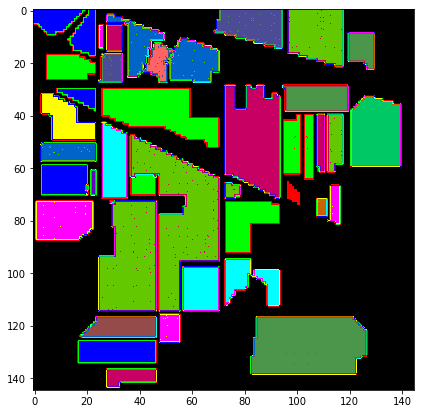

In [36]:
 predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

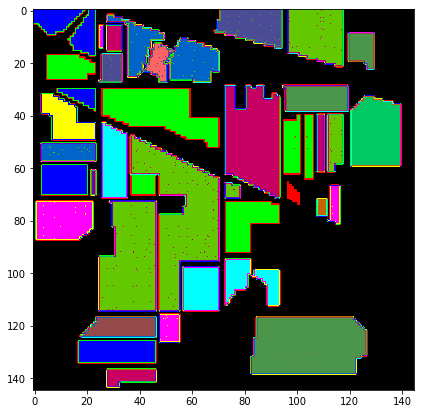

In [37]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))


In [38]:
spectral.save_rgb("C:/Users/DELL/Desktop/predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [39]:
spectral.save_rgb("C:/Users/DELL/Desktop/org.jpg",y, colors=spectral.spy_colors)